<h3>Spotify Music Classification using Audio Features</h3>

In [10]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

sb.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [11]:
spotify_df = pd.read_csv('278k_song_labelled.csv')
spotify_df.head()

,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
0,0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07,2
1,1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1
2,2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1
3,3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0
4,4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1


In [12]:
spotify_df.shape

(277938, 13)

<h4>1. Exploratory Data Analysis  <h4>

In [14]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277938 entries, 0 to 277937
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration (ms)     277938 non-null  float64
 1   danceability      277938 non-null  float64
 2   energy            277938 non-null  float64
 3   loudness          277938 non-null  float64
 4   speechiness       277938 non-null  float64
 5   acousticness      277938 non-null  float64
 6   instrumentalness  277938 non-null  float64
 7   liveness          277938 non-null  float64
 8   valence           277938 non-null  float64
 9   tempo             277938 non-null  float64
 10  spec_rate         277938 non-null  float64
 11  labels            277938 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 25.4 MB


- Distribution analysis of audio features

Distribution analysis of audio features


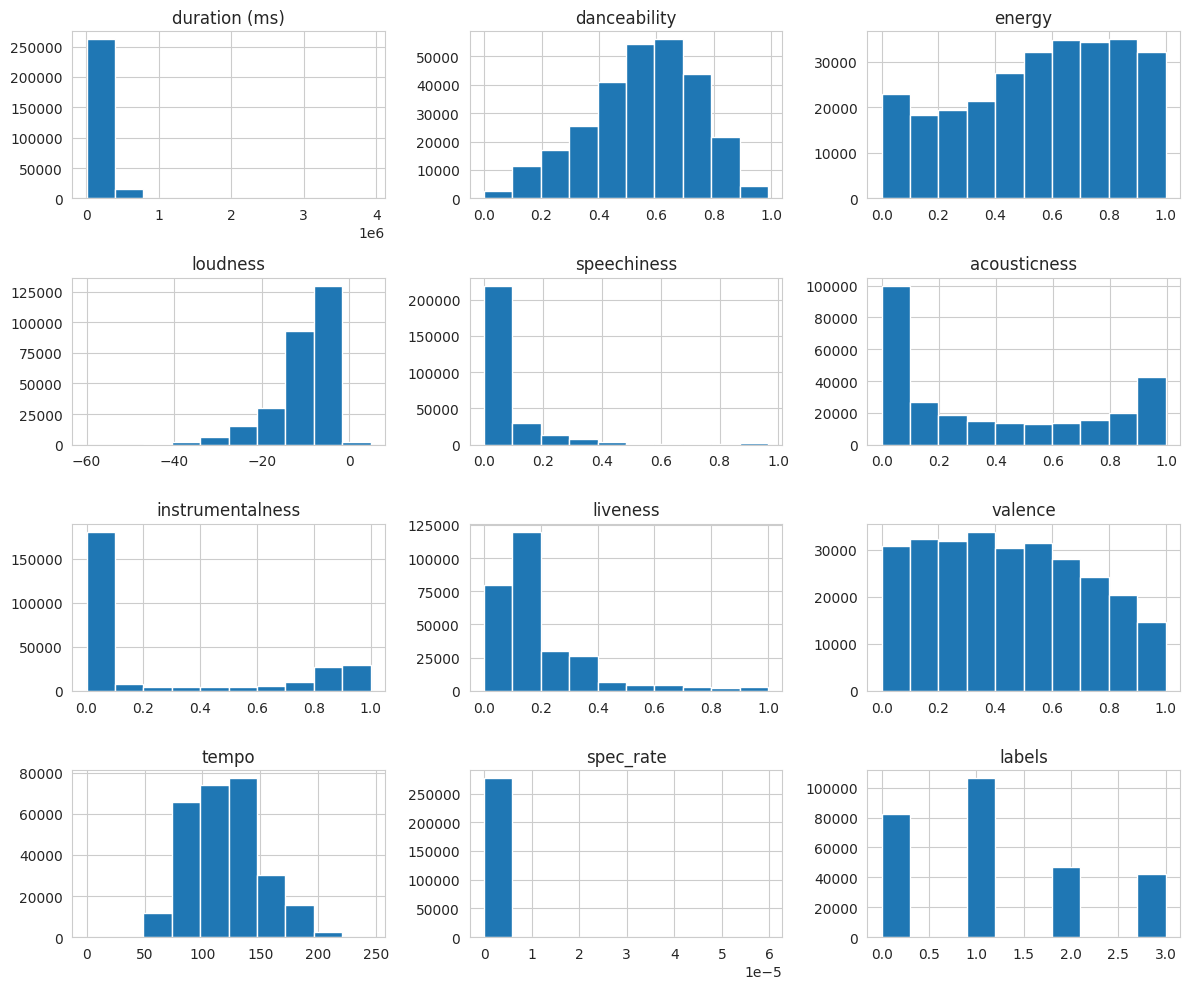

In [15]:
print('Distribution analysis of audio features')
spotify_df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

- Correlation between features and target labels

CorrelaƟon between features and target labels


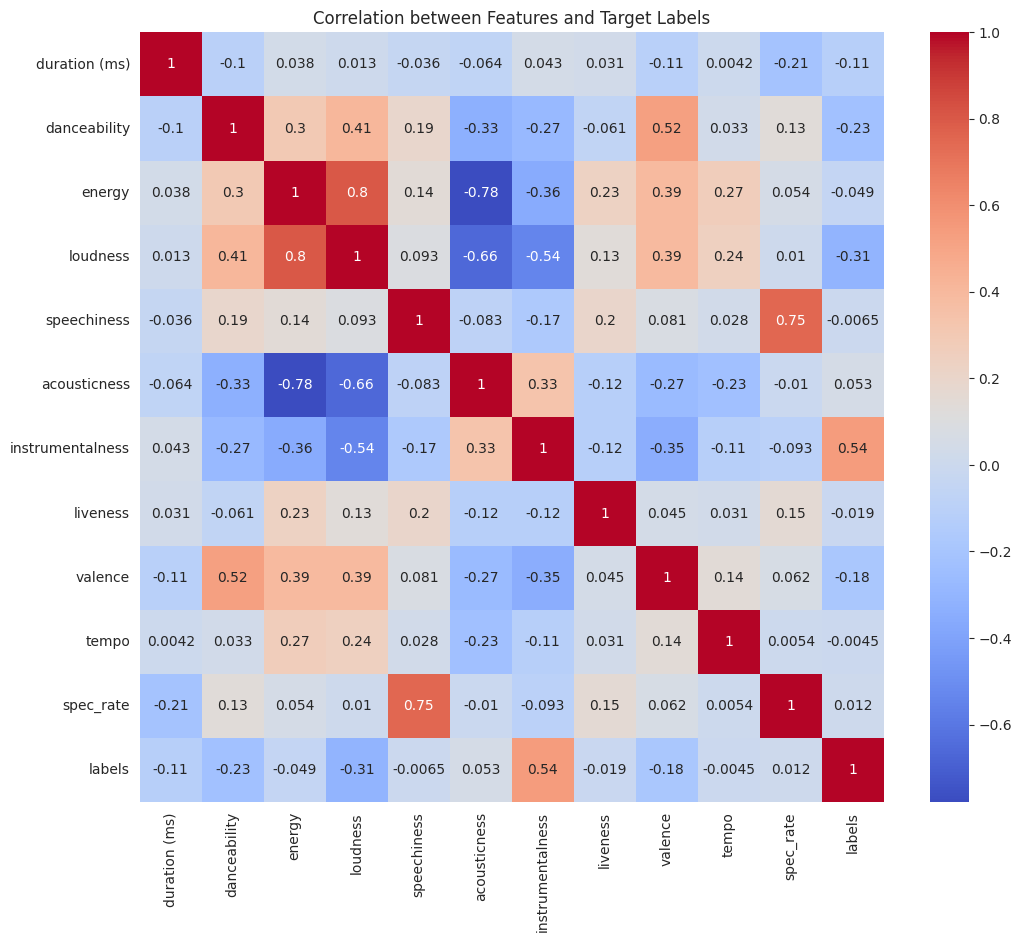

In [ ]:
print('Correlation between features and target labels')
plt.figure(figsize=(12, 10))
plt.title("Correlation between Features and Target Labels")
sb.heatmap(spotify_df.corr(), annot=True, cmap='coolwarm')
plt.show()

- Class balance inspection

In [17]:
print(f"Target Classes Inspection\n{spotify_df['labels'].value_counts()}")

Target Classes Inspection
labels
1    106429
0     82058
2     47065
3     42386
Name: count, dtype: int64


- Visualization of feature patterns per label

Visualization of feature patterns per label


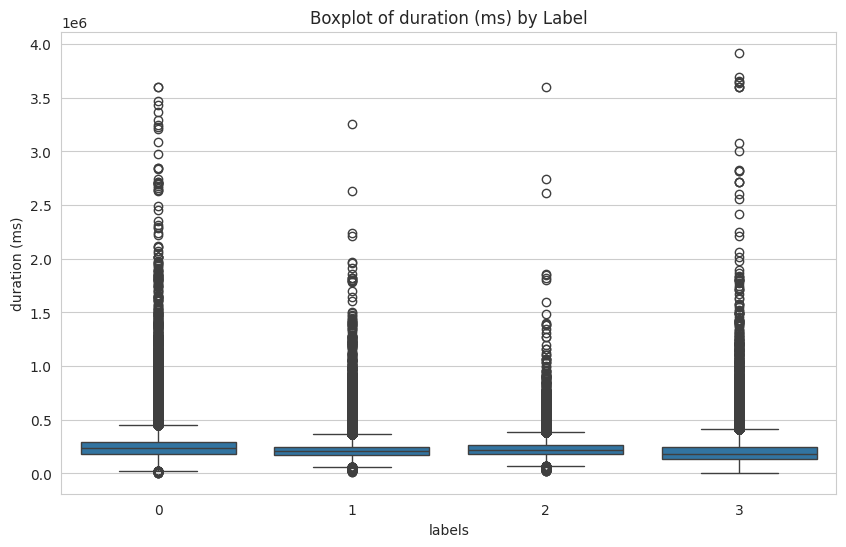

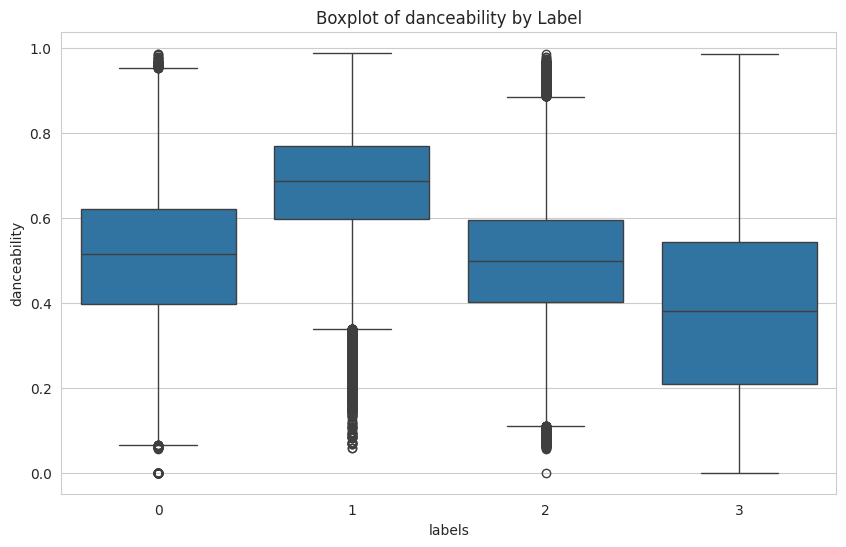

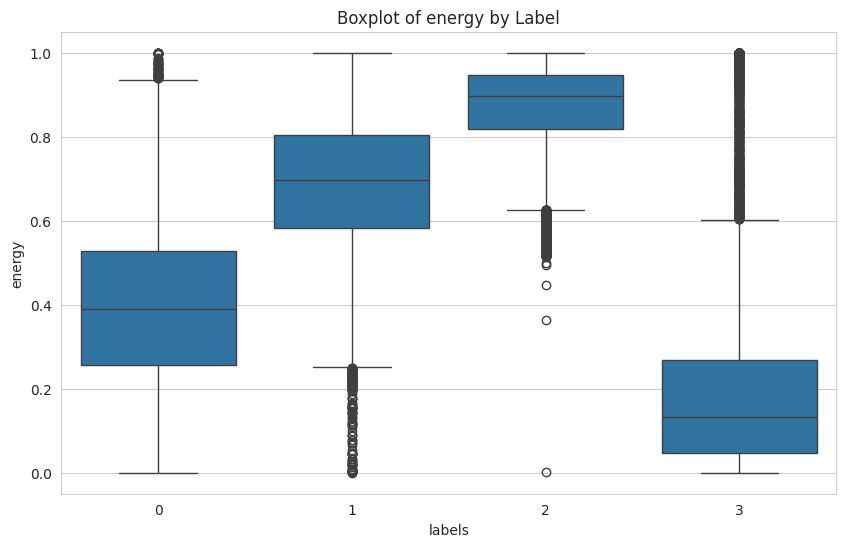

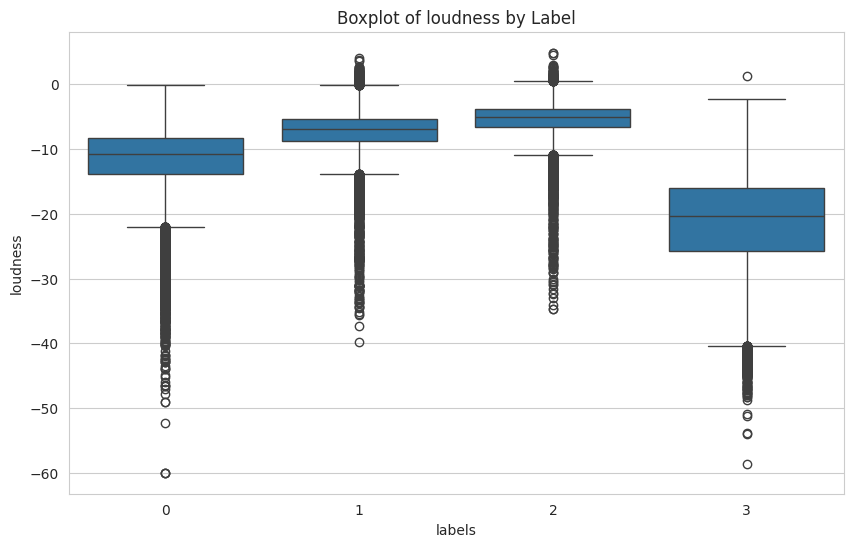

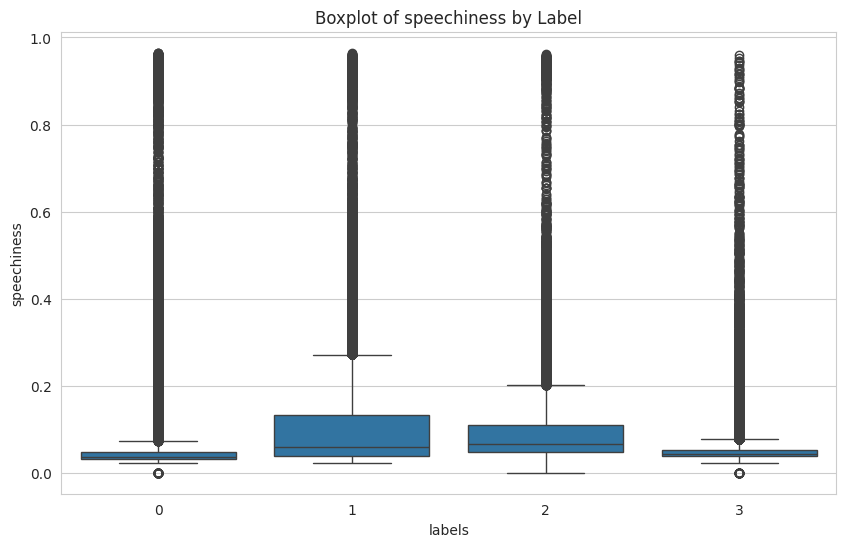

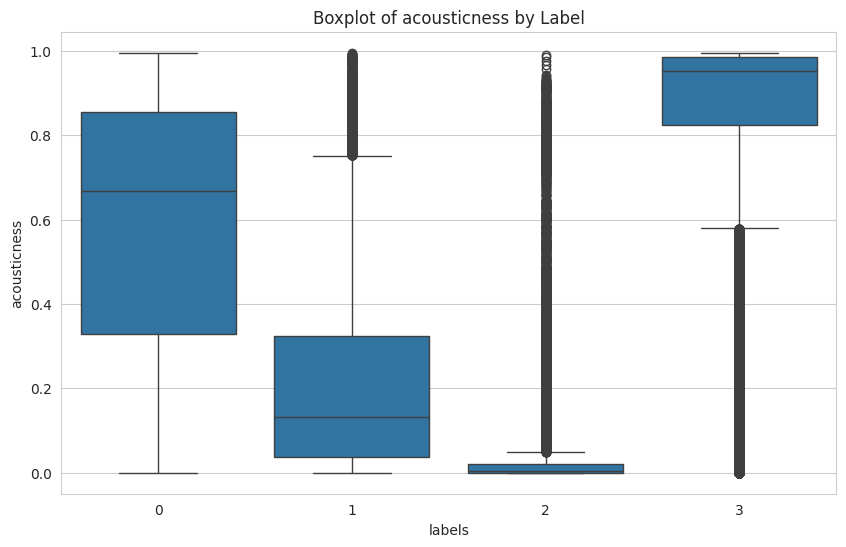

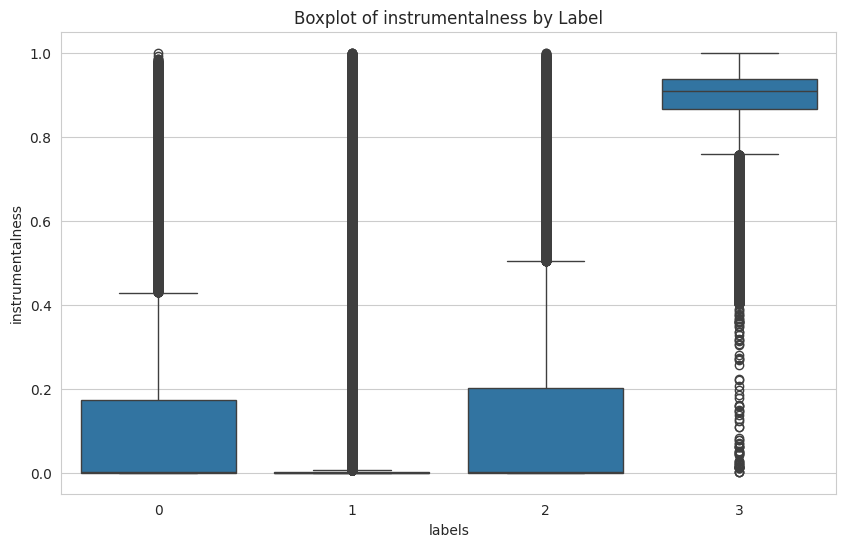

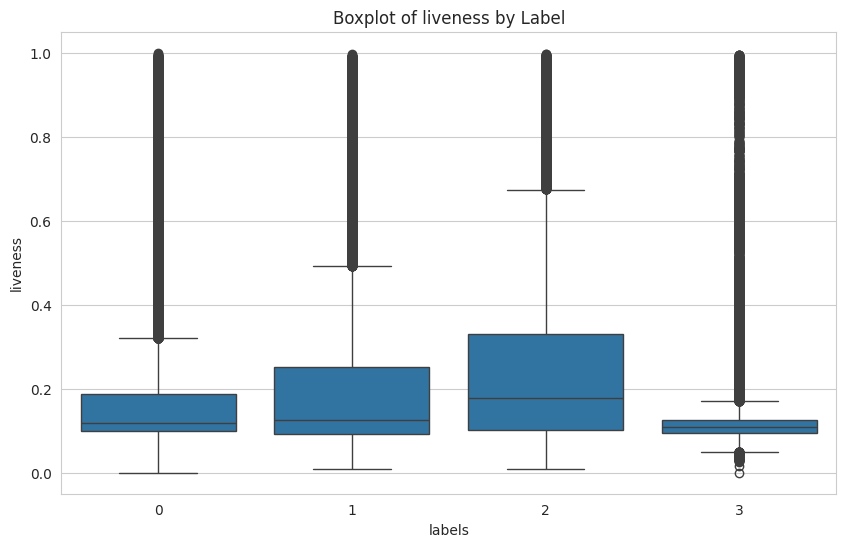

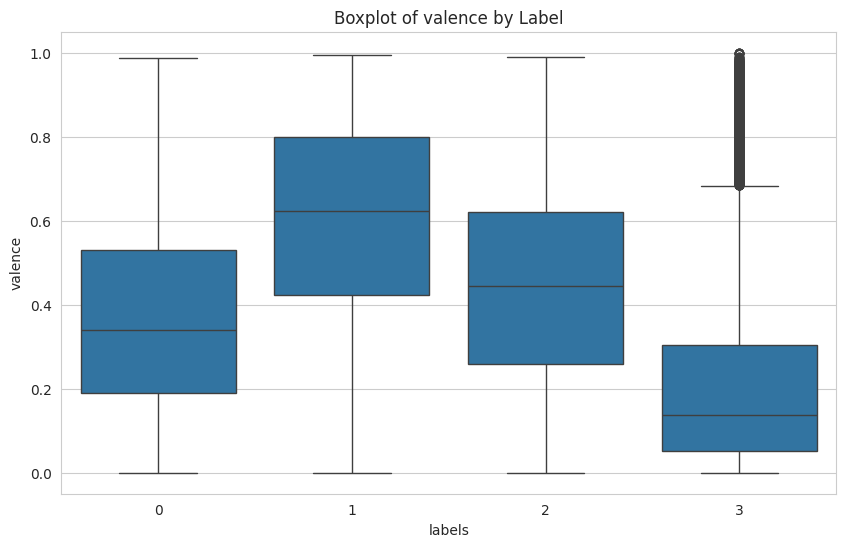

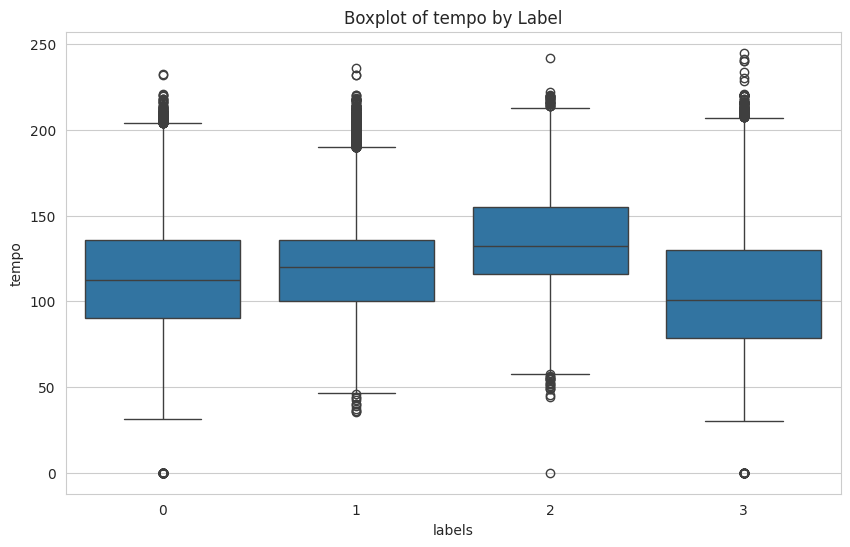

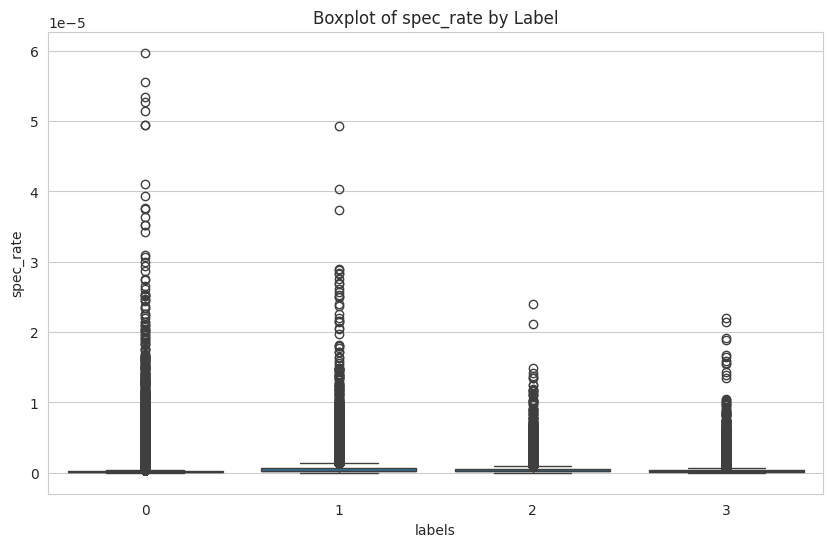

In [18]:
print("Visualization of feature patterns per label")
for cols in spotify_df.columns[:-1]:  #excludes the 'labels' column
    sb.boxplot(x='labels', y=cols, data=spotify_df)
    plt.title(f'Boxplot of {cols} by Label')
    plt.show()

<h4>2. Data Preprocessing<h4>

- Handle missing values and outliers

In [19]:
spotify_df.isna().sum()

,0
duration (ms),0
danceability,0
energy,0
loudness,0
speechiness,0
acousticness,0
instrumentalness,0
liveness,0
valence,0
tempo,0


- Encode categorical labels: labels are already encoded in the dataset

In [21]:
spotify_df['labels'] = spotify_df['labels'].convert_dtypes(int)
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277938 entries, 0 to 277937
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration (ms)     277938 non-null  float64
 1   danceability      277938 non-null  float64
 2   energy            277938 non-null  float64
 3   loudness          277938 non-null  float64
 4   speechiness       277938 non-null  float64
 5   acousticness      277938 non-null  float64
 6   instrumentalness  277938 non-null  float64
 7   liveness          277938 non-null  float64
 8   valence           277938 non-null  float64
 9   tempo             277938 non-null  float64
 10  spec_rate         277938 non-null  float64
 11  labels            277938 non-null  Int64  
dtypes: Int64(1), float64(11)
memory usage: 25.7 MB


- Handling Data Imbalance by using the Oversampling Method

In [22]:
df_0 = spotify_df[spotify_df['labels'] == 0]
df_1 = spotify_df[spotify_df['labels'] == 1]
df_2 = spotify_df[spotify_df['labels'] == 2]
df_3 = spotify_df[spotify_df['labels'] == 3]

count_1, count_0, count_2, count_3 = spotify_df['labels'].value_counts()
count_1, count_0, count_2, count_3

(np.int64(106429), np.int64(82058), np.int64(47065), np.int64(42386))

In [23]:
df_0_over = df_0.sample(count_1, replace=True)
df_2_over = df_2.sample(count_1, replace=True)
df_3_over = df_3.sample(count_1, replace=True)

balanced_df = pd.concat([df_0_over, df_1, df_2_over, df_3_over], axis=0)
print(f"Balanced Classes Inspection\n{balanced_df['labels'].value_counts()}")

Balanced Classes Inspection
labels
0    106429
1    106429
2    106429
3    106429
Name: count, dtype: Int64


- Feature scaling using StandardScaler

In [ ]:
x = balanced_df.drop(['Unnamed: 0','labels'], axis=1)
y  =  balanced_df['labels']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

- Train-test split (e.g., 80/20)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)

<h4>3. Model training<h4>

In [26]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'LightGBM': LGBMClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': LinearSVC(max_iter=1000, dual=False)
}

#training
for name, model in models.items():
    print("Model Training")
    print(f"Training {name}...")
    model.fit(x_train, y_train)
    print(f"{name} trained successfully.\n")

Model Training
Training Random Forest...
Random Forest trained successfully.

Model Training
Training Decision Tree...
Decision Tree trained successfully.

Model Training
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2802
[LightGBM] [Info] Number of data points in the train set: 340572, number of used features: 11
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
LightGBM trained successfully.

Model Training
Training Logistic Regression...
Logistic Regression trained successfully.

Model Training
Training SVM...
SVM trained successfully.



<h4>4. Model Evaluation<h4>

In [27]:
def evaluate_metrics(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return acc, prec, rec, f1

def plot_confusion(y_test, y_pred, model_name):
    with sb.axes_style("white"):
        plt.figure(figsize=(8, 6))
        cmatrix = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
        disp.plot(cmap='Blues', colorbar=False)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.show()


def plot_roc_curve(y_test, y_proba, model_name):
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    print(f"ROC AUC Score: {auc:.4f}")

- Evaluation Results

Accuracy: 0.9758
Precision: 0.9758
Recall: 0.9758
F1 Score: 0.9757
Random Forest ROC AUC: 0.9991


<Figure size 800x600 with 0 Axes>

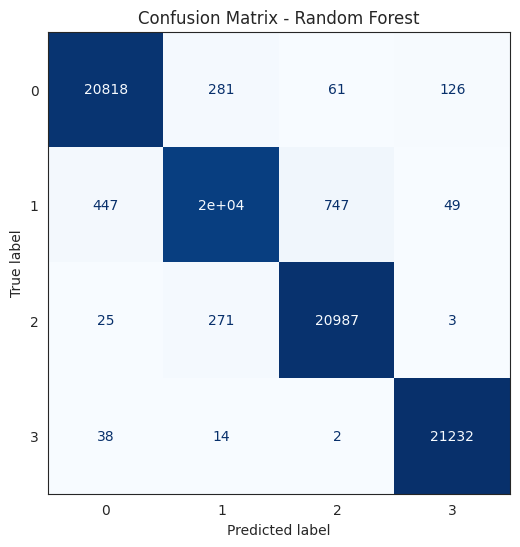

Accuracy: 0.9598
Precision: 0.9599
Recall: 0.9598
F1 Score: 0.9596
Decision Tree ROC AUC: 0.9732


<Figure size 800x600 with 0 Axes>

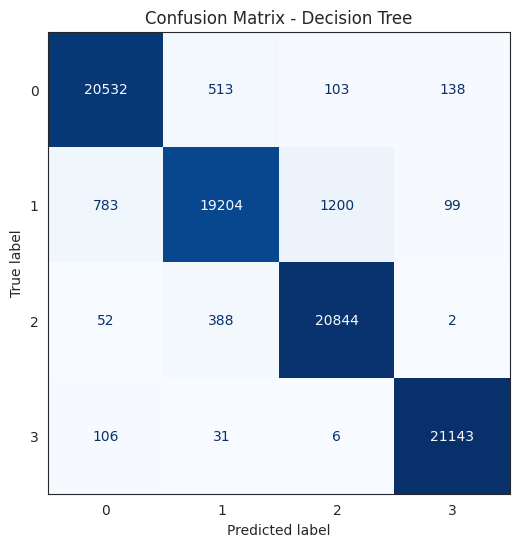

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9687
Precision: 0.9687
Recall: 0.9687
F1 Score: 0.9686


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM ROC AUC: 0.9985


<Figure size 800x600 with 0 Axes>

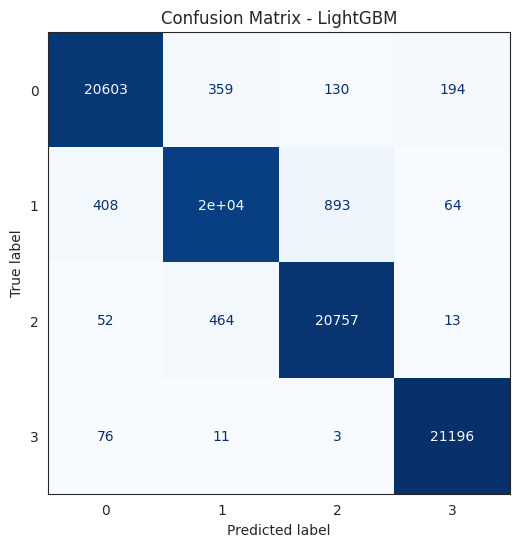

Accuracy: 0.8470
Precision: 0.8461
Recall: 0.8470
F1 Score: 0.8462
Logistic Regression ROC AUC: 0.9698


<Figure size 800x600 with 0 Axes>

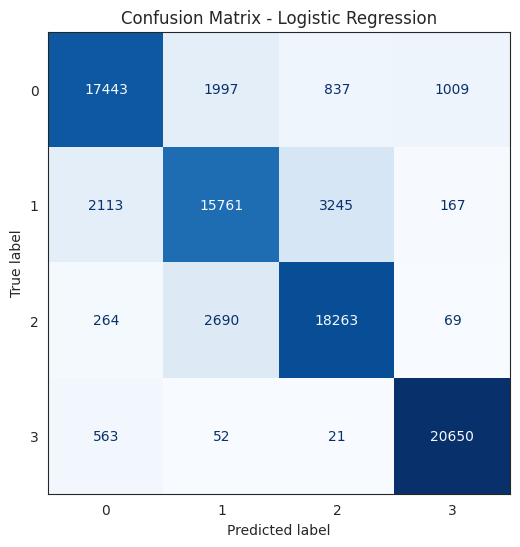

Accuracy: 0.8176
Precision: 0.8152
Recall: 0.8176
F1 Score: 0.8148


<Figure size 800x600 with 0 Axes>

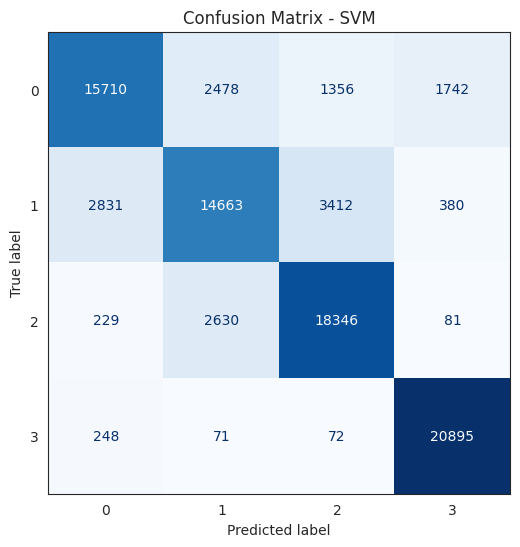

In [28]:
results = []

for name, model in models.items():
    y_pred = model.predict(x_test)
    acc, prec, rec, f1 = evaluate_metrics(y_test, y_pred)

    model_result = {
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test)
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
        model_result['ROC AUC'] = auc
        print(f"{name} ROC AUC: {auc:.4f}")
    else:
        model_result['ROC AUC'] = None

    results.append(model_result)
    plot_confusion(y_test, y_pred, name)

- Cross Validation: Stratified k-fold cross-validation and return mean and std of accuracy.

In [29]:
def cross_validate_model(model, X, y, cv=3):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    mean_score = scores.mean()
    std_score = scores.std()
    print(f"CV Accuracy: {mean_score:.4f} ± {std_score:.4f}")
    return mean_score, std_score

- Store the evaluation scores in a df

In [30]:
results_df = pd.DataFrame(results)
results_df['CV Mean Accuracy'] = 0.0
results_df['CV Std Accuracy'] = 0.0

for i, row in results_df.iterrows():
    model_name = row['Model']
    model = models[model_name]
    mean_cv, std_cv = cross_validate_model(model, x_scaled, y, cv=5)
    results_df.at[i, 'CV Mean Accuracy'] = mean_cv
    results_df.at[i, 'CV Std Accuracy'] = std_cv

results_df

CV Accuracy: 0.9757 ± 0.0005
CV Accuracy: 0.9602 ± 0.0006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2802
[LightGBM] [Info] Number of data points in the train set: 340572, number of used features: 11
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2802
[LightGBM] [Info] Number of data points in the train set: 340573, number of used features: 11
[LightGBM] [Info] Start training from score -1.386297
[LightGBM] [Info] Start training from score -1.386297
[LightGBM] [Info] Start training from score -1.386297
[LightGBM] [Info] Start training from score -1.386286


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2802
[LightGBM] [Info] Number of data points in the train set: 340573, number of used features: 11
[LightGBM] [Info] Start training from score -1.386297
[LightGBM] [Info] Start training from score -1.386297
[LightGBM] [Info] Start training from score -1.386286
[LightGBM] [Info] Start training from score -1.386297


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2803
[LightGBM] [Info] Number of data points in the train set: 340573, number of used features: 11
[LightGBM] [Info] Start training from score -1.386297
[LightGBM] [Info] Start training from score -1.386286
[LightGBM] [Info] Start training from score -1.386297
[LightGBM] [Info] Start training from score -1.386297


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2802
[LightGBM] [Info] Number of data points in the train set: 340573, number of used features: 11
[LightGBM] [Info] Start training from score -1.386286
[LightGBM] [Info] Start training from score -1.386297
[LightGBM] [Info] Start training from score -1.386297
[LightGBM] [Info] Start training from score -1.386297


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CV Accuracy: 0.9681 ± 0.0007
CV Accuracy: 0.8471 ± 0.0009
CV Accuracy: 0.8174 ± 0.0005


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,CV Mean Accuracy,CV Std Accuracy
0,Random Forest,0.975759,0.975787,0.975759,0.975674,0.999120,0.975688,0.000486
1,Decision Tree,0.959821,0.959906,0.959821,0.959583,0.973214,0.960168,0.000644
2,LightGBM,0.968677,0.968684,0.968677,0.968603,0.998514,0.968120,0.000693
3,Logistic Regression,0.847000,0.846070,0.847000,0.846195,0.969810,0.847128,0.000909
4,SVM,0.817603,0.815231,0.817603,0.814808,NaN,0.817402,0.000549


/tmp/ipython-input-3774684846.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')


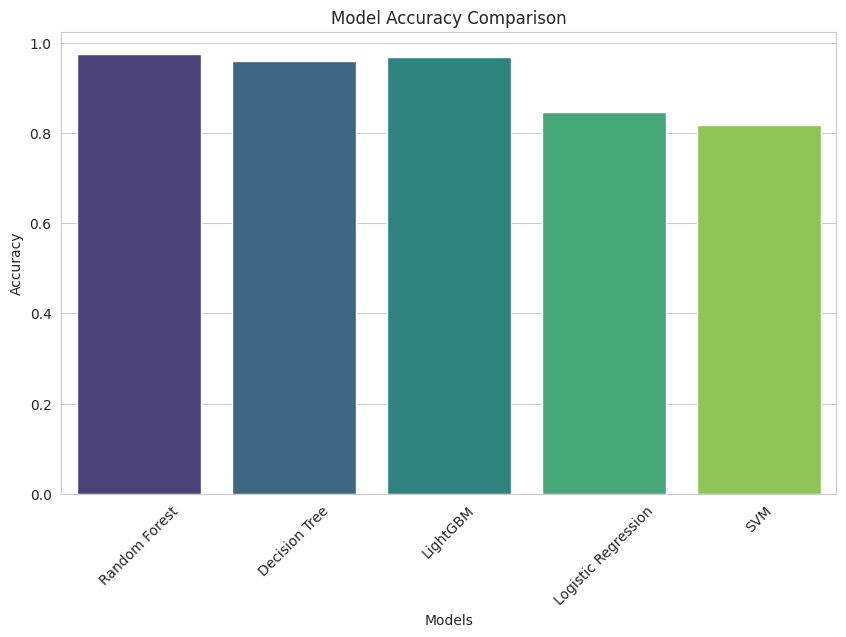

In [31]:
plt.figure(figsize=(10, 6))
sb.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

- Save models

In [32]:
joblib.dump(models, "trained_models.pkl")
print("All trained models saved to 'trained_models.pkl'")

All trained models saved to 'trained_models.pkl'


In [33]:
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved to 'scaler.pkl'")

Scaler saved to 'scaler.pkl'
